In [1]:
!pip install split-folders


In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import pathlib
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up Kaggle API and download the dataset
os.environ['KAGGLE_USERNAME'] = 'your_kaggle_username'  # replace with your Kaggle username
os.environ['KAGGLE_KEY'] = 'your_kaggle_key'  # replace with your Kaggle API key

!kaggle datasets download -d puneet6060/intel-image-classification

# Unzip the downloaded dataset
with zipfile.ZipFile('intel-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

import splitfolders


Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
100% 345M/346M [00:16<00:00, 23.2MB/s]
100% 346M/346M [00:16<00:00, 21.9MB/s]


In [3]:
# Function to create dataset for multiclass classification
def create_data_multiclass(data_bs):
    data_bs = pathlib.Path(data_bs)
    splitfolders.ratio(data_bs, output='/kaggle/working/Imgs/', seed=1234, ratio=(0.7, 0.15, 0.15), group_prefix=None)
    data_gen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        samplewise_center=True,
        samplewise_std_normalization=True
    )
    train_ds = data_gen.flow_from_directory('/kaggle/working/Imgs/train/', target_size=(img_height, img_width),
                                            class_mode='categorical', batch_size=batch_size, subset='training')
    val_ds = data_gen.flow_from_directory('/kaggle/working/Imgs/val/', target_size=(img_height, img_width),
                                          class_mode='categorical', batch_size=batch_size, shuffle=False)
    test_ds = data_gen.flow_from_directory('/kaggle/working/Imgs/test/', target_size=(img_height, img_width),
                                           class_mode='categorical', batch_size=batch_size, shuffle=False)
    return train_ds, val_ds, test_ds

# Configuration
epochs = 10
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)

# Load data
train_data, val_data, test_data = create_data_multiclass('/kaggle/working/seg_train/seg_train/')


Copying files: 14034 files [00:02, 6694.02 files/s]


Found 9820 images belonging to 6 classes.
Found 2102 images belonging to 6 classes.
Found 2112 images belonging to 6 classes.


In [4]:
# Load InceptionV3 model and modify for multiclass classification
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
x = tf.keras.layers.GlobalAveragePooling2D()(inception.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(train_data.num_classes, activation='softmax')(x)
model_inception = tf.keras.models.Model(inputs=inception.input, outputs=x)
model_inception.summary()

# Freeze initial layers
for layer in model_inception.layers[:249]:
    layer.trainable = False
optimizer = Adam(learning_rate=0.001)
model_inception.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_inception.summary()


87910968/87910968 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [5]:
# Train the model
history_inception = model_inception.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5, monitor='val_loss', mode='min',
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            patience=2, monitor='val_loss',
            mode='min', factor=0.1
        )
    ]
)


Epoch 1/10
307/307 [==============================] - 192s 560ms/step - loss: 0.6459 - accuracy: 0.7804 - val_loss: 0.4149 - val_accuracy: 0.8487 - lr: 0.0010
Epoch 2/10
307/307 [==============================] - 178s 579ms/step - loss: 0.4609 - accuracy: 0.8453 - val_loss: 0.3472 - val_accuracy: 0.8887 - lr: 0.0010
Epoch 3/10
307/307 [==============================] - 165s 537ms/step - loss: 0.4126 - accuracy: 0.8662 - val_loss: 0.3468 - val_accuracy: 0.8815 - lr: 0.0010
Epoch 4/10
307/307 [==============================] - 162s 526ms/step - loss: 0.3770 - accuracy: 0.8765 - val_loss: 0.3606 - val_accuracy: 0.8801 - lr: 0.0010
Epoch 5/10
307/307 [==============================] - 164s 535ms/step - loss: 0.3423 - accuracy: 0.8824 - val_loss: 0.2981 - val_accuracy: 0.8991 - lr: 0.0010
Epoch 6/10
307/307 [==============================] - 173s 564ms/step - loss: 0.3427 - accuracy: 0.8840 - val_loss: 0.3179 - val_accuracy: 0.8858 - lr: 0.0010
Epoch 7/10
307/307 [==========================

In [6]:
# Evaluate the model
loss_inception, acc_inception = model_inception.evaluate(test_data)


66/66 [==============================] - 34s 510ms/step - loss: 0.2866 - accuracy: 0.9010


66/66 [==============================] - 35s 456ms/step
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       330
           1       0.98      0.97      0.98       342
           2       0.82      0.85      0.83       362
           3       0.84      0.84      0.84       378
           4       0.93      0.92      0.93       342
           5       0.95      0.91      0.93       358

    accuracy                           0.90      2112
   macro avg       0.91      0.91      0.91      2112
weighted avg       0.90      0.90      0.90      2112



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


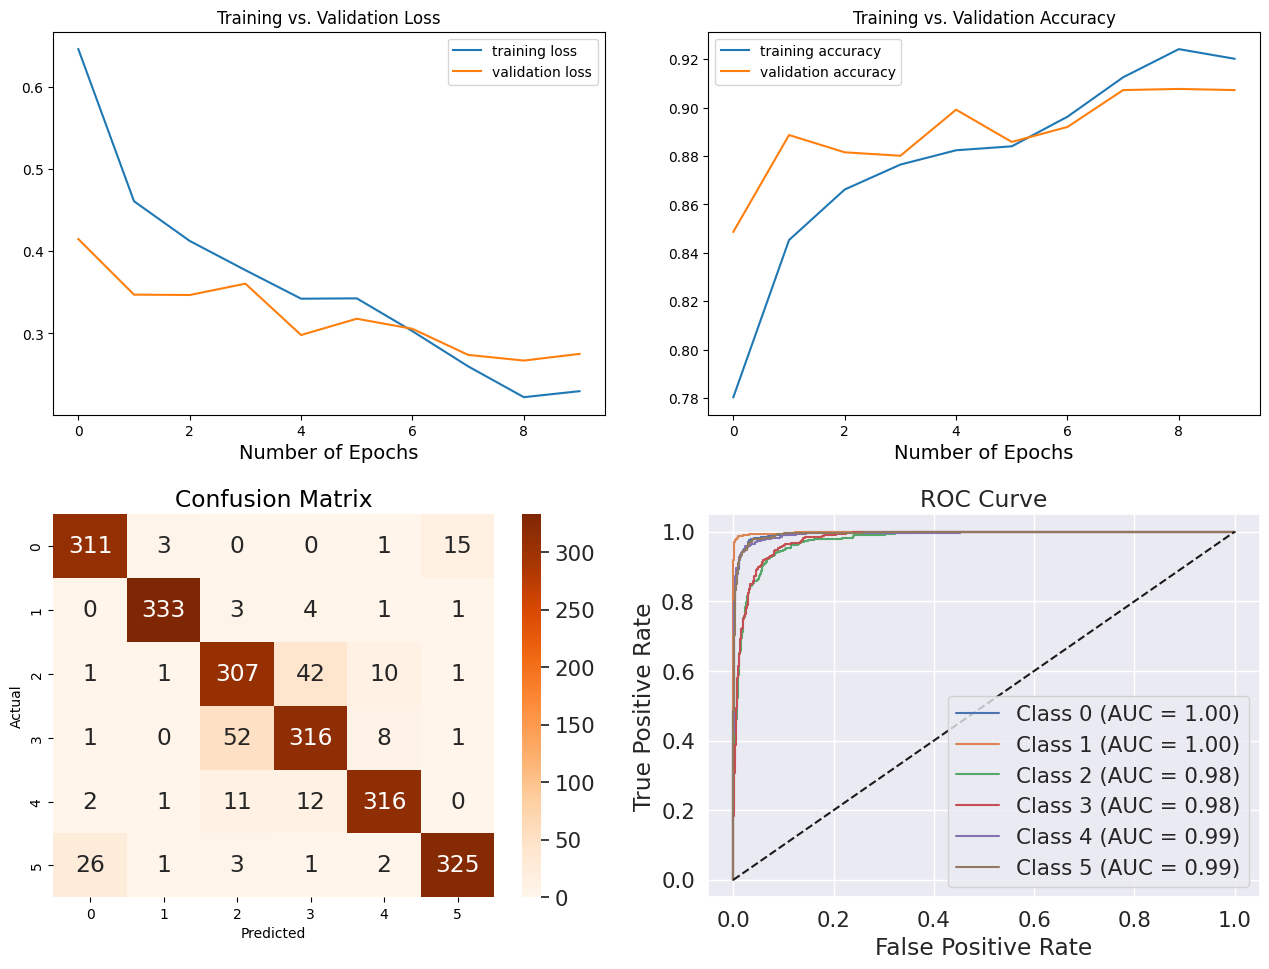

In [7]:
# Plotting function
def create_charts(cnn, cnn_model):
    ## DEFINE ##
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    train_acc = cnn_model.history['accuracy']
    val_acc = cnn_model.history['val_accuracy']
    y_true = test_data.classes
    Y_pred = cnn.predict(test_data)
    y_pred = np.argmax(Y_pred, axis=1)

    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))

    ## PLOT 1: TRAIN VS. VALIDATION LOSS
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION ACCURACY
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation Accuracy")
    plt.plot(train_acc, label='training accuracy')
    plt.plot(val_acc, label='validation accuracy')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    cm = confusion_matrix(y_true, y_pred)
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    y_true_bin = label_binarize(y_true, classes=[i for i in range(train_data.num_classes)])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(train_data.num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i in range(train_data.num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')

    ## END PLOTS
    plt.tight_layout()

    ## Summary Statistics
    print(classification_report(y_true, y_pred))

# Create charts and save the model
create_charts(model_inception, history_inception)
model_inception.save('/content/drive/MyDrive/Inception_Image_Classification.h5')


In [13]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive/m')

# Save the model to Google Drive
model_inception.save('/content/drive/MyDrive/my_model.h5')


ValueError: Mountpoint must not already contain files

In [11]:
model_inception.save('model.h5')

# Load the entire model
from tensorflow.keras.models import load_model
loaded_model = load_model('model.h5')